In [34]:
import pandas as pd
import numpy as np
import random

In [54]:
ENABLE_LOGGING = True


def log(data, message="\n"):
    if ENABLE_LOGGING:
        print("{}:  {}".format(message, data))

In [55]:
from sklearn.preprocessing import LabelBinarizer


def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html#sklearn.preprocessing.LabelBinarizer
    lb = LabelBinarizer()
    lb.fit(range(max(x) + 1))
    b = lb.transform(x)
    return b

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

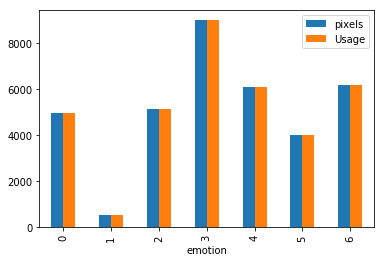

In [83]:
file = r'data/fer2013.csv'
df = pd.read_csv(file)

g1 = df.groupby( [ "emotion"] ).count()
g1.head(10)
my_plot = g1.plot(kind='bar')

## Data

### Training

In [65]:
df.loc[df['Usage'] == 'Training'].head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### Test

In [53]:
df.loc[df['Usage'] == 'PublicTest'].head(5)

,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest


### Pre-process Data 

In [57]:
# Converting space separated pixels to int array
def string_to_int_array(item):
    return [int(p) for p in item.split()]


def get_X_and_y(df):
    X = [string_to_int_array(item) for item in df.iloc[:, 1].values]
    X = np.array(X) / 255.0
    y = np.array(df.iloc[:, 0].values)
    y = np.array(one_hot_encode(y))
    y = y.astype(np.float32, copy=False)
    return X, y


def get_training_set(data):
    not_class1 = data.loc[data['emotion'] != 1]
    class1 = data.loc[data['emotion'] == 1]
    class1_aug = class1
    # This is done to handle the class imbalance for emotion 1 which has only ~500 pics
    for i in range(11):
        class1_aug = class1_aug.append(class1)
    complete_training_set = not_class1.append(class1_aug)
    return get_X_and_y(complete_training_set)

In [58]:
def get_test_set(data):
    return get_X_and_y(data)


train_X, train_y = get_training_set(df.loc[df['Usage'] == 'Training'])
test_X, test_y = get_test_set(df.loc[df['Usage'] == 'PublicTest'])
validate_X, validate_y = get_test_set(df.loc[df['Usage'] == 'PrivateTest'])

In [42]:
train_X.shape

(33505, 2304)

## Images

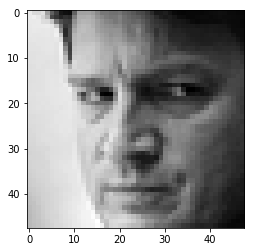

In [47]:
plt.imshow(train_X[random.randint(1,train_X.shape[0])].reshape(48,48),cmap='gist_gray')    

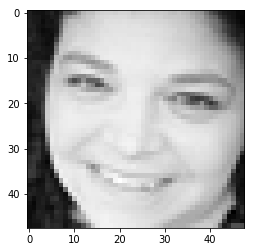

In [48]:
plt.imshow(train_X[random.randint(1,train_X.shape[0])].reshape(48,48),cmap='gist_gray')

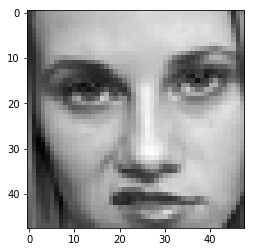

In [49]:
plt.imshow(train_X[random.randint(1,train_X.shape[0])].reshape(48,48),cmap='gist_gray')

In [8]:
from sklearn.utils import shuffle
import tensorflow as tf
def get_batch(X, y, current_batch, batch_size):
    X_batch = X[current_batch * batch_size:(
        current_batch * batch_size + batch_size)]
    y_batch = y[current_batch * batch_size:(
        current_batch * batch_size + batch_size)]
    return X_batch, y_batch

### Hyper parameters

In [60]:

num_batches = 128
batch_size = 256
epocs = 1000
learning_rate=0.2


## Linear Classification

In [33]:
labels = 7
image_size = 2304

x = tf.placeholder(tf.float32, shape=[None, image_size])
W = tf.Variable(tf.zeros([image_size, labels]))
b = tf.Variable(tf.zeros([labels]))
y = tf.matmul(x, W) + b
y_true = tf.placeholder(tf.float32, [None, labels])
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(cross_entropy)
init = tf.global_variables_initializer()
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_true, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
with tf.Session() as sess:
    sess.run(init)
    for step in range(epocs):
        X, y = shuffle(train_X, train_y)
        for current_batch in range(num_batches):
            batch_X, batch_y = get_batch(X, y, current_batch, batch_size)
            sess.run(train, feed_dict={x: batch_X, y_true: batch_y})
        if step % 100 == 0:
            log(sess.run(accuracy, feed_dict={x: test_X,
                                              y_true: test_y}), "model accuracy")

    log(sess.run(accuracy, feed_dict={x: validate_X,
                                      y_true: validate_y}), "Final accuracy")

model accuracy:  0.11730287224054337
model accuracy:  0.12789078056812286
model accuracy:  0.31429368257522583
model accuracy:  0.20841459929943085
model accuracy:  0.2947896420955658
model accuracy:  0.3390916585922241
model accuracy:  0.3441070020198822
model accuracy:  0.30509892106056213
model accuracy:  0.3039844036102295
model accuracy:  0.24630816280841827
Final accuracy:  0.2518807351589203


### Hyper parameters

In [77]:

num_batches = 64
batch_size = 256
epocs = 100
learning_rate=0.001


In [84]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)


def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)


def conv2d(x, W):
    # x --> [batch,H,W,channels]
    # W --> [filter H, filter W, Channels In, Channels Out]
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME")


def max_pool_2x2(x):
    # x --> [batch,H,W,channels]
    return tf.nn.max_pool(
        x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")


def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)


def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b


x = tf.placeholder(tf.float32, shape=[None, image_size])
y_true = tf.placeholder(tf.float32, shape=[None, labels])
x_image = tf.reshape(x, [-1, 48, 48, 1])

# In[37]:

convo_1 = convolutional_layer(x_image, shape=[5, 5, 1, 32])
convo_1_pooling = max_pool_2x2(convo_1)

# In[38]:

convo_2 = convolutional_layer(convo_1_pooling, shape=[5, 5, 32, 64])
convo_2_pooling = max_pool_2x2(convo_2)

# In[40]:

# Why 12 by 12 image? Because we did 2 pooling layers, so (48/2)/2 = 12
convo_2_flat = tf.reshape(convo_2_pooling, [-1, 12 * 12 * 64])
full_layer_1 = tf.nn.relu(normal_full_layer(convo_2_flat, 1024))

# In[41]:

# Dropout
hold_prob = tf.placeholder(tf.float32,name="hold_prob")
full_one_dropout = tf.nn.dropout(full_layer_1, keep_prob=hold_prob)

# In[42]:

y_pred = normal_full_layer(full_one_dropout, labels)

# In[44]:

# Loss function
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=y_pred))

# In[45]:

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(cross_entropy)

# In[46]:

init = tf.global_variables_initializer()
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# In[47]:

with tf.Session() as sess:
    sess.run(init)
    for step in range(epocs):
        log(step,"Epoch")
        X, y = shuffle(train_X, train_y)
        for current_batch in range(num_batches):
            batch_X, batch_y = get_batch(X, y, current_batch, batch_size)
            sess.run(
                train, feed_dict={
                    x: batch_X,
                    y_true: batch_y,
                    hold_prob: 0.5
                })
        if True:
            log(
                sess.run(
                    accuracy,
                    feed_dict={
                        x: test_X,
                        y_true: test_y,
                        hold_prob: 1.0
                    }), "model accuracy")
    log(
        sess.run(
            accuracy,
            feed_dict={
                x: validate_X,
                y_true: validate_y,
                hold_prob: 1.0
            }), "Final accuracy")

Epoch:  0
model accuracy:  0.2794650197029114
Epoch:  1
model accuracy:  0.3413206934928894
Epoch:  2
model accuracy:  0.36779046058654785
Epoch:  3
model accuracy:  0.37419894337654114
Epoch:  4
model accuracy:  0.3909166753292084
Epoch:  5
model accuracy:  0.411813884973526
Epoch:  6
model accuracy:  0.4257453382015228
Epoch:  7
model accuracy:  0.42295902967453003
Epoch:  8
model accuracy:  0.4274170994758606
Epoch:  9
model accuracy:  0.4380050301551819
Epoch:  10
model accuracy:  0.4555586576461792
Epoch:  11
model accuracy:  0.4586235582828522
Epoch:  12
model accuracy:  0.4586235582828522
Epoch:  13
model accuracy:  0.46503204107284546
Epoch:  14
model accuracy:  0.47645583748817444
Epoch:  15
model accuracy:  0.469490110874176
Epoch:  16
model accuracy:  0.4817498028278351
Epoch:  17
model accuracy:  0.4845360815525055
Epoch:  18
model accuracy:  0.4845360815525055
Epoch:  19
model accuracy:  0.48620784282684326
Epoch:  20
model accuracy:  0.4845360815525055
Epoch:  21
model ac